## **Item Based Collaborative Filtering**

This notebook explains how to use the Amazon Reviews Dataset to build a item-based recommender using latent factorized collaborative filtering with Spark's Alternating Least Saqures (ALS) implementation. 

It is organised in two parts:
The first one is about getting and parsing titles and ratings data into Spark 

1.   Visualizing the preformance of ALS based on input parameters
2.   Given an item of choice, recommending relevant items



> This notebook gives an inference about similar products, given products of choice. 



***Setting up the pyspark envirnoment***

In [0]:
# Install pyspark and initiate
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.6.tgz
!tar xf spark-2.4.5-bin-hadoop2.6.tgz
!pip install -q findspark

In [0]:
#Envirnoment set up
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.6"

In [0]:
#Spark session creation
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
#Import libraries
import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS
from pyspark.ml.feature import StringIndexer

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#Creating an object to run SparkContext and configuration parameters set up
sc = spark.sparkContext
spark.conf.set("spark.executor.memory", '8g')
spark.conf.set('spark.executor.cores', '3')
spark.conf.set('spark.cores.max', '3')
spark.conf.set("spark.driver.memory",'8g')

In [6]:
#Drive mounting 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


***Analyzing the ratings dataset***

In [7]:
#Creating a RDD
data = spark.read \
    .format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("/content/drive/My Drive/AmazonRatings")
data.withColumn('userID', data.userID.cast(IntegerType()))
data.withColumn('productID', data.productID.cast(IntegerType()))
data.withColumn('rating', data.rating.cast(FloatType()))

DataFrame[userID: int, productID: int, rating: float]

In [0]:
#Summary of the data
data.describe().show()

+-------+-----------------+----------------+------------------+
|summary|           userID|       productID|            rating|
+-------+-----------------+----------------+------------------+
|  count|            50000|           50000|             50000|
|   mean|       6825.52462|      1647.20638|             4.297|
| stddev|6079.531320262724|2040.66577409514|1.1438431568809393|
|    min|                0|               0|               1.0|
|    max|            21677|            8851|               5.0|
+-------+-----------------+----------------+------------------+



In [0]:
#Understanding the schema of the data
data.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- productID: integer (nullable = true)
 |-- rating: double (nullable = true)



In [0]:
print('Distinct values of ratings:')
print(sorted(data.select('rating').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:
[1.0, 2.0, 3.0, 4.0, 5.0]


In [0]:
temp1 = data.groupBy("userID").count().toPandas()['count'].min()
temp2 = data.groupBy("productID").count().toPandas()['count'].min()
print('For the users that rated items and the items that were rated:')
print('Minimum number of ratings per user is {}'.format(temp1))
print('Minimum number of ratings per item is {}'.format(temp2))

For the users that rated items and the items that were rated:
Minimum number of ratings per user is 1
Minimum number of ratings per item is 1


In [0]:
count = data.select('userID').distinct().count()
print('Total number of distinct users are: {} in the data'.format(count))

Total number of distinct users are: 21678 in the data


In [0]:
count = data.select('productID').distinct().count()
print('Total number of distinct items are: {} in the data'.format(count))

Total number of distinct items are: 8852 in the data


## **Steps for building recommendation model using ALS**


*   Load the data as a spark RDD dataframe
*   Split the data into train, test and validation dataset (6:2:2)
*   Train the ALS model with train data using different input parameters:
        - Number of iterations
        - Number of latent factors
        - Number of regularizations



***Load the Spark RDD data***

In [0]:
ratings = sc.textFile('/content/drive/My Drive/AmazonRatings')

# preprocess data -- only need ["userId", "productId", "rating"]
header = ratings.take(1)[0]
rating_data = ratings \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()

In [9]:
rating_data.take(4)

[(20, 4391, 4.0), (20, 4391, 4.0), (946, 2883, 5.0), (946, 2883, 5.0)]

***Train-Validation-Test Split***

In [10]:
train, validation, test = rating_data.randomSplit([6, 2, 2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[17] at RDD at PythonRDD.scala:53

In [11]:
# Each dataset size
print('Train dataset size: ', train.count())
print('Validation dataset size: ', validation.count())
print('Test dataset size: ' ,test.count())

Train dataset size:  29829
Validation dataset size:  10149
Test dataset size:  10022


***Training the model with different input parameters***

In [0]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                nonnegative = True,
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [34]:
# hyper-param config
num_iterations = 5
ranks = [10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)
print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

10 latent factors and regularization = 0.001: validation RMSE is 3.8862582022966667
10 latent factors and regularization = 0.01: validation RMSE is 2.0685580467217615
10 latent factors and regularization = 0.05: validation RMSE is 1.6366131301314546
10 latent factors and regularization = 0.1: validation RMSE is 1.542165048422527
10 latent factors and regularization = 0.2: validation RMSE is 1.4617201012741474
12 latent factors and regularization = 0.001: validation RMSE is 3.3721834947478047
12 latent factors and regularization = 0.01: validation RMSE is 2.0127573632264166
12 latent factors and regularization = 0.05: validation RMSE is 1.6598461080290603
12 latent factors and regularization = 0.1: validation RMSE is 1.5756098141965846
12 latent factors and regularization = 0.2: validation RMSE is 1.4938474923659772
14 latent factors and regularization = 0.001: validation RMSE is 3.60193085063171
14 latent factors and regularization = 0.01: validation RMSE is 1.9024970227996185
14 laten

***Plotting the model for different number of iterations***

In [0]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            nonnegative = True,
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors, marker='s',c='g')
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

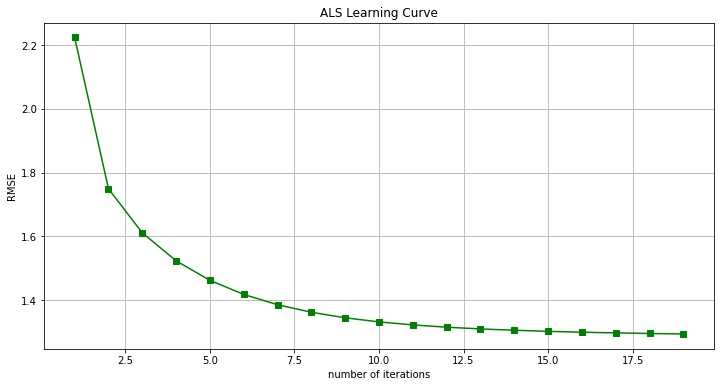

In [0]:
# create an array of num_iters
iter_array = list(range(1, 20))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.2, 10)

***Plotting the model for different number of latent factors***

In [0]:
def plot_learning_curve(ranks, train_data, validation_data, reg, iters):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for rank in ranks:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=iters,
            rank=rank,
            lambda_=reg,           # regularization param
            nonnegative = True,
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(ranks, errors,marker='s',c='r')
    plt.xlabel('number of latent factors')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

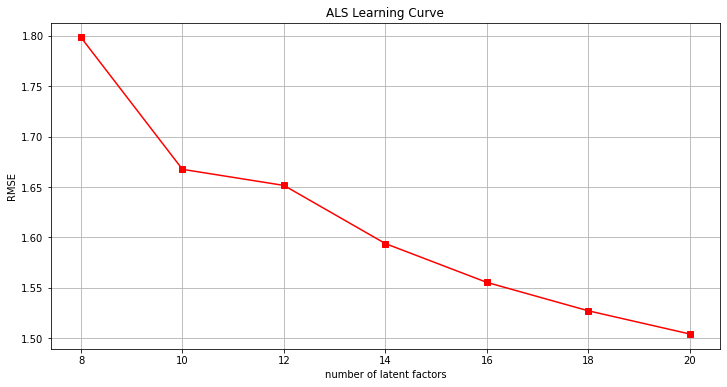

In [0]:
# create an array of latent factors
rank_array = [8,10,12,14,16,18,20]
# create learning curve plot
plot_learning_curve(rank_array, train, validation, 0.01, 15)

***Evaluation on test data***

In [0]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 1.4883


In [0]:
#Plotting the predictions
predictions.take(20)

[((9200, 286), 2.571978601691752),
 ((5618, 203), 4.81312272111132),
 ((4926, 1645), 2.3661862455201135),
 ((8390, 53), 3.8393389102177125),
 ((3706, 886), 2.7095479305236383),
 ((1596, 18), 2.168200537692793),
 ((1596, 18), 2.168200537692793),
 ((9336, 2709), 3.3476333021284326),
 ((4724, 2747), 0.29765803853937844),
 ((1732, 454), 4.799518767670065),
 ((1732, 454), 4.799518767670065),
 ((2602, 461), 3.8831169913793966),
 ((1550, 37), 4.133109607717692),
 ((11084, 2786), 4.9012353448756505),
 ((1310, 1457), 2.429872954157286),
 ((1202, 138), 2.20288098497994),
 ((2192, 66), 4.75782602985089),
 ((3118, 4010), 4.93750633583022),
 ((7134, 1877), 4.854220596217139),
 ((5204, 97), 4.761799481190472)]

***Predictions and analysis of best model***

In [0]:
#original vs predictions
ratesAndPreds.take(20)

[((477, 1449), (5.0, 4.705894710349848)),
 ((3145, 601), (5.0, 4.9972345128228355)),
 ((2038, 1440), (5.0, 4.900238389027521)),
 ((2866, 416), (5.0, 4.7506889733290745)),
 ((849, 1005), (5.0, 3.0297701323003876)),
 ((11466, 1580), (2.0, 1.9327245650960498)),
 ((3134, 1432), (5.0, 4.852891553883378)),
 ((7019, 55), (5.0, 4.778057149664647)),
 ((311, 1511), (3.0, 2.628505276596183)),
 ((311, 1511), (3.0, 2.628505276596183)),
 ((311, 1511), (3.0, 2.628505276596183)),
 ((311, 1511), (3.0, 2.628505276596183)),
 ((1079, 2947), (5.0, 0.6280320311163534)),
 ((25, 1561), (5.0, 4.91418609822861)),
 ((957, 1141), (5.0, 4.2817410281122)),
 ((12532, 1874), (5.0, 4.876260893980344)),
 ((414, 224), (1.0, 1.2454781463434177)),
 ((11744, 82), (4.0, 3.8270133041672114)),
 ((2535, 239), (5.0, 4.854087677708743)),
 ((3311, 1695), (5.0, 4.9651040603385175))]

In [0]:
final_model.userFeatures().sortByKey().take(2)

[(0,
  array('d', [0.20377470552921295, 0.5628600716590881, 0.40561437606811523, 0.4612044394016266, 0.708041787147522, 0.5044846534729004, 0.41496211290359497, 0.9613056182861328, 0.46496254205703735, 0.4898398220539093])),
 (1,
  array('d', [0.8054433465003967, 0.6690448522567749, 0.6552834510803223, 1.0386834144592285, 0.16884833574295044, 0.8438513278961182, 0.7182007431983948, 0.224129319190979, 0.7702435851097107, 0.8051297068595886]))]

In [0]:
final_model.productFeatures().sortByKey().take(2)

[(0,
  array('d', [1.0645198822021484, 0.1909005045890808, 0.17491741478443146, 0.7126218676567078, 0.22311843931674957, 0.9023882746696472, 0.42078256607055664, 0.4214809834957123, 0.4533446133136749, 0.47181436419487])),
 (1,
  array('d', [0.2400311529636383, 0.4040917754173279, 0.7909649610519409, 0.6326550841331482, 0.2040405422449112, 0.9815348982810974, 0.19623591005802155, 0.5687397718429565, 0.8260688781738281, 0.5692168474197388]))]

In [0]:
np.dot( 
    final_model.userFeatures().sortByKey().take(1)[0][1], 
    final_model.productFeatures().sortByKey().take(1)[0][1] 
)

2.358886686980523

In [0]:
product = sc.parallelize([(0, 500)]) 
individual_rating_RDD = final_model.predictAll(product)
individual_rating_RDD.collect()

[Rating(user=0, product=500, rating=3.756836091085288)]

## **Making Recommendations of Products**

In [0]:
#reload the data
ratings = sc.textFile('/content/drive/My Drive/AmazonRatings')

# preprocess data -- only need ["userId", "productId", "rating"]
header = ratings.take(1)[0]
rating_data = ratings \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()

In [15]:
#Checking the tuple
rating_data.take(10)

[(20, 4391, 4.0),
 (20, 4391, 4.0),
 (946, 2883, 5.0),
 (946, 2883, 5.0),
 (4622, 1491, 5.0),
 (4622, 1491, 5.0),
 (9825, 79, 2.0),
 (9825, 79, 2.0),
 (7545, 2015, 5.0),
 (7545, 2015, 5.0)]

In [0]:
#Load the titles data
pd.options.display.max_colwidth = 100
title_df = pd.read_csv('/content/drive/My Drive/AmazonTitles')

In [0]:
#Drop the duplicates in titles data
title_df.drop_duplicates(subset = ['productID'],inplace = True)

In [18]:
#Total products
print('Number of unique products: ', title_df.shape[0])

Number of unique products:  8852


In [19]:
#Display of productID's with their respective titles
pd.options.display.max_colwidth = 100
title_df.head(20)

,productID,title
0,4391,George Foreman GR20WHT XL Grill
2,2883,"Polder 307T 307 Preset Thermometer, White"
4,1491,Hamilton Beach 52204 Blender/Food Processor
6,79,Zojirushi NHS-10 6-Cup (Uncooked) Rice Cooker
8,2015,"Le Creuset Enameled Cast-Iron 2-1/4-Quart Pumpkin Casserole, Flame"
10,1449,OXO Good Grips Garlic Press
12,4994,OXO 20581 Grater
14,136,Hoffritz Stainless-Steel Mandoline Slicer
18,753,Cuisipro Stainless Steel Measuring Spoon Set
20,381,Norpro Egg Perfect Egg Timer


In [0]:
#Create a spark dataframe
titles = spark.createDataFrame(title_df)



> **get_itemId**: This function returns the productsID's corresponding to user's choice of products



>> 1.   Input parameters: title data and user's item list
2.   Return parameter: list of productID's correspponding to user choice




In [0]:
def get_itemId(df_titles, mylist):
    itemID_list = []
    for item in mylist:
        itemIds = df_titles \
            .filter(titles.title.like('%{}%'.format(item))) \
            .select('productID') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        itemID_list.extend(itemIds)
    return list(set(itemID_list))

> **add_data_to_train**: This function returns the new training data including the new user to the existing training data



>> 1.   Input parameters: training data and user's item list
2.   Return parameter: new training data

In [0]:
def add_data_to_train(train_data, item_list):
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # get max rating
    max_rating = train_data.map(lambda r: r[2]).max()
    # create new user rdd
    user_rows = [(new_id, item, max_rating) for item in item_list]
    new_rdd = sc.parallelize(user_rows)
    # return new train data
    return train_data.union(new_rdd)

> **get_modified**: This function returns the inference data where we exclude the items of users choice and then make predictions



>> 1.   Input parameters: training data, title data and user's item list
2.   Return parameter: test data for prediction

In [0]:
def get_modified(train_data, title_data, item_list):
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # return inference rdd
    return title_data.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in item_list) \
        .map(lambda x: (new_id, x))

***Making Recommendations by training the best model***

In [0]:
def get_recommendations(best_model_params, ratings_data, title_data, 
                        mylist,toprecs):
    # modify train data by adding new user's rows
    prod_list = get_itemId(title_data, mylist)
    train_data = add_data_to_train(ratings_data, prod_list)
    
    # train best ALS
    model = ALS.train(
        ratings=train_data,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=99)
    
    # get inference rdd
    inference_rdd = get_modified(ratings_data, title_data, prod_list)
    
    # inference
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))
    
    # get top n productids
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(toprecs)
    topn_ids = [r[0] for r in topn_rows]
    
    # return titles for top products
    return title_data.filter(title_data.productID.isin(topn_ids)) \
                    .select('title') \
                    .rdd \
                    .map(lambda r: r[0]) \
                    .collect()

### A) Test for a single item from the item list(title data) available

In [26]:
# my items
my_item_list = ['Zojirushi NHS-10 6-Cup (Uncooked) Rice Cooker']

# get recommends
recommends = get_recommendations(
    best_model_params={'iterations': 15, 'rank': 10, 'lambda_': 0.2}, 
    ratings_data=rating_data, 
    title_data=titles, 
    mylist=my_item_list,
    toprecs=10)

print('Recommendations for {}:'.format(my_item_list[0]))
for i, title in enumerate(recommends):
    print('{0}: {1}'.format(i+1, title))

Recommendations for Zojirushi NHS-10 6-Cup (Uncooked) Rice Cooker:
1: Fiesta 10-1/4-Inch Deep Dish Pie Baker, Sunflower
2: Norpro Silcone Basting/Pastry Brush
3: Mastrad Silicone Spoon, Blue
4: Mastrad 12-Inch Stainless and Silicone Tongs
5: Le Creuset Enameled Cast-Iron 15-3/4-by-10-3/4-Inch Rectangular Roaster, Cherry
6: Orka Gourmet 27-Ounce Round Steamer, Blue
7: J.A. Henckels Bellasera 45-Piece Flatware Set, Service for 8
8: Polder Traffic Light Kitchen Timer
9: Lodge 3.6 Quart Cast Iron Casserole Pan. Red Enamel Cast Iron Casserole Dish with Dual Handles and Lid (Island Spice Red)
10: Eureka RR Style Synthetic Bag, 3 pack


In [35]:
# my items
my_item_list = ['Cuisipro Stainless Steel Measuring Spoon Set']

# get recommends
recommends = get_recommendations(
    best_model_params={'iterations': 15, 'rank': 10, 'lambda_': 0.2}, 
    ratings_data=rating_data, 
    title_data=titles, 
    mylist=my_item_list,
    toprecs=20)

print('Recommendations for {}:'.format(my_item_list[0]))
for i, title in enumerate(recommends):
    print('{0}: {1}'.format(i+1, title))

Recommendations for Cuisipro Stainless Steel Measuring Spoon Set:
1: Polder 307T 307 Preset Thermometer, White
2: Le Creuset Enameled Cast Iron Round French Oven (5 1/2 Quart, Cherry Red)
3: Eureka 570B  Cordless Boss Upright Vacuum
4: Hamilton Beach 04162 HEPA Air Purifier with UV Germicidal Light
5: Coopers DIY Beer Home Brewing 6 Gallon All Inclusive Craft Beer Making Kit with Patented Brewing Fermenter, Beer Hydrometer, Brewing Ingredients, Bottles and Brewing Accessories
6: Medelco 4 Cup Universal Glass Espresso Replacement Carafe, Black
7: Anolon Advanced Nonstick Hard-Anodized Aluminum 8-Piece Cookware Set
8: Cuisipro Accutec Razor-Sharp Kitchen Rasp
9: Prepac Black 7-Drawer Lingerie Chest
10: The ARC Curved Shower Bar, Stainless Steel
11: Vacu Vin Foil Cutter with Magnetic Holder
12: EnviroCare Replacement Micro Filtration Vacuum Bags for Hoover Windtunnel Upright Type Y 18 Pack
13: Polder 893-90 Dual Kitchen 20-Hour Timer/Clock/Stopwatch
14: KitchenAid Silicone Mixer Spatula, 

### B) Test for 2 items from the item list(title data) available

In [30]:
# my items
my_item_list = ['Proctor-Silex 26500Y Durable Belgian Waffle Baker',
                'OXO Good Grips Garlic Press']

# get recommends
recommends = get_recommendations(
    best_model_params={'iterations': 15, 'rank': 10, 'lambda_': 0.2}, 
    ratings_data=rating_data, 
    title_data=titles, 
    mylist=my_item_list,
    toprecs = 20)

print('Recommendations for {}:'.format(my_item_list))
for i, title in enumerate(recommends):
    print('{0}: {1}'.format(i+1, title))

Recommendations for ['Proctor-Silex 26500Y Durable Belgian Waffle Baker', 'OXO Good Grips Garlic Press']:
1: Amco Stainless-Steel Cocktail Picks, Set of 4
2: Pyrex 6022369 Storage 14-Piece Round Set, Clear with Blue Lids
3: FoodSaver 1 Quart Size Bag, Package of 48
4: simplehuman KT1025 System Stainless-Steel Dish Rack
5: KitchenAid KHM900ER 9-Speed Hand-Mixer, Empire Red
6: Classic 7" Hollow Edge Santoku Knife with Board
7: MASTERCOOL (52224-A-SP Gray Infrared Thermometer with Laser
8: Polder 77-90 Diet Utility Food Scale, 18 oz./500 g Capacity, White
9: OXO Good Grips Vegetable Brush (color may vary)
10: William Bounds Sili Gourmet V-Shaped Roasting Rack
11: Melitta Coffee Maker, 6 Cup Pour-Over Brewer with Glass Carafe, 1-Count
12: Bardwil Reflections Spill Proof Oblong / Rectangle Tablecloth, 60-Inch x 102-Inch, Pearl
13: Cuisinart TOB-195 Exact Heat Toaster Oven Broiler, Stainless
14: Lodge 10-1/4-Inch Cast-Iron Lid
15: Weber 7514 Warm-Up Basket (24.3 x 4 x 0.6)
16: Brentwood Orig

### **Getting a quick review of our recommendations**

#### **My purchased list:**
> 1. [Waffle Baker](https://www.amazon.com/Proctor-Silex-26500Y-Durable-Belgian-Waffle/dp/B00004X13D)
2. [Rice Cooker](https://www.amazon.com/OXO-Grips-Soft-Handled-Garlic-Press/dp/B00HEZ888K)

#### **Top 5 Recommendations:**
> 1. [Stainless Steel Set](https://www.amazon.com/Amco-Stainless-Steel-Cocktail-Picks-Set/product-reviews/B00005N9DL)
2. [Storage Set](https://www.amazon.com/Pyrex-692264408076-6022369-Storage-14-Piece/product-reviews/B0000CFTB0)
3. [Bed Sheet Set](https://www.amazon.com/FoodSaver-BPA-Free-Multilayer-Construction-Preservation/dp/B01D5TM5MS)
4. [Dish Rack](https://www.amazon.com/simplehuman-kt1025-system-stainless-steel-dish/dp/b000c2205e)
5. [Hand Mixer](https://www.amazon.com/gp/product/B000JLFLYU)

## Conclusion:

#### The ALS recommender does a decent job in recommending relevant items. Carefully designing the model by finding the best parameters has improvised the results.

#### Though the recommendations makes sense, in the above cell, the recommendation of Storage Set given the favourite list is waffle baker and cooker does not show very good results.

#### These recommendations are further compared with the results recommendations made by LDA model where the reviewText is being taken into consideration.